In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
file_path = "Counterlist-DE.txt"
data = open(file_path,'r')

In [4]:
data=[]
with open(file_path,'r') as f:    
    lines = f.readlines()[1:]
    for line in lines:
        line = line.replace('"', '')
        elements = line.strip().split("\t")
        data.append(elements)

In [5]:
columns=data[0]
data = data[1:]

In [6]:
df = pd.DataFrame(data=data, columns=columns)

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [8]:
None

In [9]:
pratiques_path = "pratiques.csv"
pratiques_df = pd.read_csv(pratiques_path, encoding= 'unicode_escape')

In [10]:
pratiques_df['pratiques'] = pratiques_df['pratiques'].str.replace(";", "%3B")

In [11]:
pratiques_df=pratiques_df[['idPdc','pratiques']]
pratiques_df.dropna(subset=['idPdc'], inplace=True)

In [12]:
pratiques_df['idPdc']=pratiques_df['idPdc'].astype('int32')
df['idPdc']=df['idPdc'].astype('int32')

In [13]:
pd.merge(df, pratiques_df, on='idPdc')
None

In [15]:
df[df['nom'].str.contains("\?")]
None

In [16]:
df = df.replace("L??rrach (DE)","Loerrach (DE)")
df = df.replace("L??rrach_2 (DE)","Loerrach_2 (DE)")
df = df.replace("G??ttingen (DE)","Goettingen (DE)")
df = df.replace("G??ttingen_1 (DE)","Goettingen_1 (DE)")
df = df.replace("G??ttingen_2 (DE)","Goettingen_2 (DE)")
df = df.replace("D??sseldorf (DE)","Duesseldorf (DE)")
df = df.replace("T??bingen (DE)","Tuebingen (DE)")
df = df.replace("Osnabr??ck (DE)","Osnabrueck (DE)")
df = df.replace("M??lheim (DE)","Muelheim (DE)")
df = df.replace("M??nster_Hammer Stra??e (DE)","Muenster_Hammer Strasse (DE)")

In [18]:
df.head()
None

In [19]:
import requests
import json
from datetime import datetime

unique_date = []
data_sets = []

def create_request():
    json_data={}
  
    for index, row in df.iterrows():
        url = 'http://data.eco-counter.com/ParcPublic/CounterData'
        start_day, start_month, start_year = row.debut.split('/')
        today_day, today_month, today_year = datetime.today().strftime('%d/%m/%Y').split('/')
        pratiques = ""
        if hasattr(row, 'pratiques'):
            pratiques="&pratiques="+row.pratiques
        body = "idOrganisme=4586&idPdc={}&fin={}%2F{}%2F{}&debut={}%2F{}%2F{}&interval=4&pratiques={}".format(row.idPdc, today_day, today_month, today_year, start_day, start_month, start_year, pratiques)

        headers = {
            "Accept": "text/plain, */*; q=0.01",
            "Accept-Encoding": "gzip, deflate",
            "Accept-Language": "en-US,en;q=0.9",
            "Connection": "keep-alive",
            "Content-Length": "115",
            "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8",
            "Cookie": "i18next=en_US; _ga=GA1.2.1682226698.1584790632; _gid=GA1.2.220973166.1584790632",
            "Host": "data.eco-counter.com",
            "Origin": "http://data.eco-counter.com",
            "Referer": "http://data.eco-counter.com/ParcPublic/?id=4586",
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.80 Safari/537.36",
            "X-Requested-With": "XMLHttpRequest"
        }
        x = requests.post(url, body, headers=headers)   

        for entry in x.json()[:-1]:
            data_set={}
            date = str(entry[0]) 
            formatted_date = datetime.strptime(date, '%m/%d/%Y').strftime('%Y-%m-%d')   
            data_set['date']= formatted_date
            data_set['bike_count']= str(entry[1])
            data_set['name']= row['nom']
            data_set['lon']=row['lon']
            data_set['lat']=row['lat']
            data_sets.append(data_set)
            if formatted_date not in unique_date:
                unique_date.append(formatted_date)
    return data_sets

In [20]:
json_data = create_request()

In [72]:
df_new = pd.DataFrame(data=json_data)

In [73]:
# add a column that contains the station_string
def f(x):
    """ return the station string """
    return "('%s', '%s')" % (x["lon"], x["lat"])
df_new["station_string"] = df_new.apply(f, axis=1)
df_new["date"] = df_new.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))


In [78]:
# load bike prediction modul
from prediction import BikePrediction
BT = BikePrediction()

In [84]:
# set predictions for each station by filtering df_new accordingly
stations = df_new["station_string"].unique()

df_enriched = pd.DataFrame()

for station in stations:
    print("current station", station)
    tmp = df_new.loc[df_new["station_string"]==station]
    print("len tmp", len(tmp))

    if len(tmp) > 450:
        # only predict if more than 365 days exist
        predictions = BT.predict_series(
            station_string=station,
            days=tmp["date"])
        
        tmp = tmp.join(predictions.set_index("date"), on="date")
    else:
        tmp["prediction"] = 0
    if len(df_enriched) == 0:
        df_enriched = tmp
    else:
        df_enriched.merge(tmp)
    #df_new[df_new["station_string"]==station] = tmp

current station ('8.69424', '49.406723')
len tmp 1603
current station ('7.65932', '47.6197')
len tmp 2439
current station ('9.214609', '49.139652')
len tmp 2311
current station ('9.451567', '48.64519')
len tmp 2166
current station ('12.149421548069586', '54.09152282594652')
len tmp 2465
current station ('6.7671213', '51.220154')
len tmp 1993
current station ('9.94008', '51.55311')
len tmp 2313
current station ('9.92926', '51.53692')
len tmp 1767
current station ('11.082456', '49.448765')
len tmp 1695
current station ('12.13605', '54.09034')
len tmp 2577
current station ('7.8407526', '47.995213')
len tmp 2637
current station ('8.4027153', '49.0072864')
len tmp 2637
current station ('9.048007', '48.518017')
len tmp 2466
current station ('6.3104796', '51.08195')
len tmp 1560
current station ('9.7269378', '52.3768927')
len tmp 1437
current station ('8.75178334164736', '50.112920247359')
len tmp 1421
current station ('9.739617', '52.362137')
len tmp 1405
current station ('9.735394', '52.368

In [85]:
df_new = df_enriched

In [86]:
df_new.head(5)

date bike_count               name      lon        lat  \
0 2015-11-01       1849  Heidelberg_2 (DE)  8.69424  49.406723   
1 2015-11-02       3993  Heidelberg_2 (DE)  8.69424  49.406723   
2 2015-11-03       4195  Heidelberg_2 (DE)  8.69424  49.406723   
3 2015-11-04       4224  Heidelberg_2 (DE)  8.69424  49.406723   
4 2015-11-05       4737  Heidelberg_2 (DE)  8.69424  49.406723   

             station_string   prediction  
0  ('8.69424', '49.406723')  1676.295807  
1  ('8.69424', '49.406723')  2505.542723  
2  ('8.69424', '49.406723')  3036.095000  
3  ('8.69424', '49.406723')  3135.658792  
4  ('8.69424', '49.406723')  3020.543141

In [438]:
df_new["year"] = df_new.date.apply(lambda x: x.year)
df_new["month"] = df_new.date.apply(lambda x: x.month)
df_new["weekday"] = df_new.date.apply(lambda x: x.weekday())
df_new["bike_count"] = df_new.bike_count.astype("float16")

df_new = df_new.join(pd.get_dummies(df_new.weekday, prefix="weekday"))
df_new = df_new.join(pd.get_dummies(df_new.month, prefix="month"))
df_new["name"] = df_new["name"].astype('category')
df_new["location_code"] = df_new["name"].cat.codes

df_new["workingday"] = df_new["weekday"].apply(lambda x: 1 if x < 5 else 0)
df_new["saturday"] = df_new["weekday_5"]
df_new["sunday"] = df_new["weekday_6"]

C:\Users\gabriel.jaeger\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [439]:
df_new.tail()

date  bike_count             name        lon        lat  year  \
57632 2020-01-16       188.0  Litzendorf (DE)  11.002216  49.915281  2020   
57633 2020-01-17       362.0  Litzendorf (DE)  11.002216  49.915281  2020   
57634 2020-01-18       508.0  Litzendorf (DE)  11.002216  49.915281  2020   
57635 2020-01-19       416.0  Litzendorf (DE)  11.002216  49.915281  2020   
57636 2020-01-20         0.0  Litzendorf (DE)  11.002216  49.915281  2020   

       month  weekday  weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  \
57632      1        3          0          0          0          1          0   
57633      1        4          0          0          0          0          1   
57634      1        5          0          0          0          0          0   
57635      1        6          0          0          0          0          0   
57636      1        0          1          0          0          0          0   

       weekday_5  weekday_6  month_1  month_2  month_3  month_4  month_5  \
57632          0          0        1        0        0        0        0   
57633          0          0        1        0        0        0        0   
57634          1          0        1        0        0        0        0   
57635          0          1        1        0        0        0        0   
57636          0          0        1        0        0        0        0   

       month_6  month_7  month_8  month_9  month_10  month_11  month_12  \
57632        0        0        0        0         0         0         0   
57633        0        0        0        0         0         0         0   
57634        0        0        0        0         0         0         0   
57635        0        0        0        0         0         0         0   
57636        0        0        0        0         0         0         0   

       location_code  workingday  saturday  sunday  
57632             22           1         0       0  
57633             22           1         0       0  
57634             22           0         1       0  
57635             22           0         0       1  
57636             22           1         0       0

In [451]:
import statsmodels.formula.api as sm
from matplotlib import pyplot as plt

location_codes=np.sort(df_new.location_code.unique())
print(location_codes)

df_location=df_new.loc[df_new['location_code'] == location_codes[0]]

result = sm.ols(formula="""
    bike_count ~ 
    year +
    month_1 + 
    month_2 + 
    month_3 + 
    month_4 + 
    month_5 + 
    month_6 + 
    month_7 + 
    month_8 + 
    month_9 + 
    month_10 + 
    month_11 + 
    month_12 +   
    weekday_0 + 
    weekday_1 + 
    weekday_2 + 
    weekday_3 + 
    weekday_4 + 
    weekday_5 + 
    weekday_6 
    """, data=df_location).fit()
result.summary()



[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             bike_count   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     67.02
Date:                Sun, 22 Mar 2020   Prob (F-statistic):          9.19e-128
Time:                        13:38:21   Log-Likelihood:                -3815.4
No. Observations:                 590   AIC:                             7669.
Df Residuals:                     571   BIC:                             7752.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -1.02e+05   2.42e+04     -4.219      0.000    -1.5e+05   -5.45e+04
year          62.3078     14.686      4.243      0.000      33.462      91.154
month_1    -8768.0418   2023.750     -4.333      0.000   -1.27e+04   -4793.139
month_2    -8700.6287   2023.889     -4.299      0.000   -1.27e+04   -4725.454
month_3    -8667.9223   2022.358     -4.286      0.000   -1.26e+04   -4695.753
month_4    -8522.0568   2016.500     -4.226      0.000   -1.25e+04   -4561.394
month_5    -8433.0791   2016.492     -4.182      0.000   -1.24e+04   -4472.431
month_6    -8302.1383   2016.502     -4.117      0.000   -1.23e+04   -4341.471
month_7    -8162.0312   2016.494     -4.048      0.000   -1.21e+04   -4201.380
month_8    -8334.1907   2010.327     -4.146      0.000   -1.23e+04   -4385.652
month_9    -8329.3330   2009.072     -4.146      0.000   -1.23e+04   -4383.260
month_10   -8480.4520   2009.066     -4.221      0.000   -1.24e+04   -4534.391
month_11   -8597.7598   2009.069     -4.279      0.000   -1.25e+04   -4651.693
month_12   -8728.6224   2009.069     -4.345      0.000   -1.27e+04   -4782.555
weekday_0   -1.45e+04   3454.475     -4.197      0.000   -2.13e+04   -7713.882
weekday_1  -1.446e+04   3454.475     -4.186      0.000   -2.12e+04   -7675.486
weekday_2  -1.447e+04   3454.476     -4.190      0.000   -2.13e+04   -7689.877
weekday_3  -1.449e+04   3454.548     -4.194      0.000   -2.13e+04   -7703.110
weekday_4  -1.451e+04   3454.462     -4.201      0.000   -2.13e+04   -7728.657
weekday_5  -1.473e+04   3454.475     -4.265      0.000   -2.15e+04   -7946.800
weekday_6  -1.486e+04   3454.405     -4.301      0.000   -2.16e+04   -8073.260
==============================================================================
Omnibus:                       59.610   Durbin-Watson:                   0.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.337
Skew:                          -0.658   Prob(JB):                     9.88e-23
Kurtosis:                       4.546   Cond. No.                     2.43e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.08e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

C:\Users\gabriel.jaeger\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


NameError: name 'd' is not defined

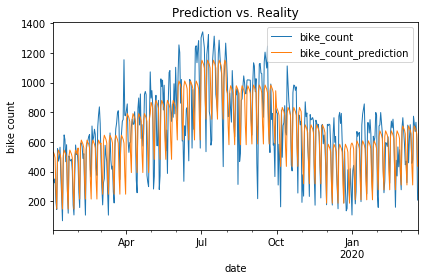

In [454]:
df_location["bike_count_prediction"] = result.predict(df_location)

df_location[(df_location.date > datetime(2019,1,1))].plot(
x="date", 
y=["bike_count", "bike_count_prediction"],
linewidth=1,
title='Prediction vs. Reality')

plt.ylabel("bike count")

plt.tight_layout()
plt.savefig("data_viz_%s.png" % d)


lens = [print(a) for a in data[d]]

df_new.head()
df_new.info()

In [296]:
whole_json = df_new.to_json(orient='records')

'[{"date":"2017-03-14","value":"1704.0","name":"Heidelberg_2 (DE)","lon":"8.69424","lat":"49.406723","usual":null},{"date":"2017-03-15","value":"3978.0","name":"Heidelberg_2 (DE)","lon":"8.69424","lat":"49.406723","usual":null},{"date":"2017-03-16","value":"4650.0","name":"Heidelberg_2 (DE)","lon":"8.69424","lat":"49.406723","usual":null},{"date":"2017-03-17","value":"3621.0","name":"Heidelberg_2 (DE)","lon":"8.69424","lat":"49.406723","usual":null},{"date":"2017-03-18","value":"839.0","name":"Heidelberg_2 (DE)","lon":"8.69424","lat":"49.406723","usual":null},{"date":"2017-03-19","value":"1565.0","name":"Heidelberg_2 (DE)","lon":"8.69424","lat":"49.406723","usual":null},{"date":"2017-03-20","value":"3220.0","name":"Heidelberg_2 (DE)","lon":"8.69424","lat":"49.406723","usual":null},{"date":"2017-03-21","value":"3852.0","name":"Heidelberg_2 (DE)","lon":"8.69424","lat":"49.406723","usual":null},{"date":"2017-03-22","value":"2375.0","name":"Heidelberg_2 (DE)","lon":"8.69424","lat":"49.4067

In [125]:
'''import boto3

s3_client = boto3.client('s3', 
    aws_access_key_id=settings.AWS_SERVER_PUBLIC_KEY, 
    aws_secret_access_key=settings.AWS_SERVER_SECRET_KEY, 
    region_name=REGION_NAME
    )'''

"import boto3\n\ns3_client = boto3.client('s3', \n    aws_access_key_id=settings.AWS_SERVER_PUBLIC_KEY, \n    aws_secret_access_key=settings.AWS_SERVER_SECRET_KEY, \n    region_name=REGION_NAME\n    )"

In [ ]:
response = s3_client.put_object(
      Bucket="sdd-s3-basebucket",
      Body=json.dumps(whole_json),     
      Key="fahrrad/whole_json.json'
    )

In [65]:
import os
path = "fahrrad_daten"
if not os.path.exists(path):
    os.mkdir(path)

for date in unique_date:
    year=date[0:4]
    month=date[5:7]
    day=date[8:10]
    path = "fahrrad_daten/"
    if not os.path.exists(path+year):
        os.mkdir(path+year)
    if not os.path.exists(path+year+"/"+month):
        os.mkdir(path+year+"/"+month)
    if not os.path.exists(path+year+"/"+month+"/"+day):
        os.mkdir(path+year+"/"+month+"/"+day)
    data_array=[]
    for i in whole_json:
        if i['datum'] == date:
            data_array.append(i)
    '''response = s3_client.put_object(
      Bucket="sdd-s3-basebucket",
      Body=json.dumps(data_array),     
      Key="fahrrad/"+year+"/"+month+"/"+day+'/{}.json'.format(year + '-' + month + '-' + day)
    )'''
    with open(path+year+"/"+month+"/"+day+'/{}.json'.format(year + '-' + month + '-' + day), 'w') as f:
        f.write(json.dumps(data_array))
    